In [ ]:
#!pip install tensorflow==2.10.0
#!pip install torch==1.12.1
#!pip install transformers==4.20.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import pandas as pd

# Reading the csv file
df = pd.read_csv('/content/drive/MyDrive/RansomwareData.csv')


Mounted at /content/drive/


In [ ]:
X = df.drop([df.columns[0], df.columns[1], df.columns[2]], axis=1).values
y = df[df.columns[2]]

y_binary = df[df.columns[1]].values

# Create group labels
def convert_to_group(label):
    if 1 <= label <= 3:
        return 1
    elif 4 <= label <= 6:
        return 2
    elif 7 <= label <= 9:
        return 3
    elif 10 <= label <= 12:
        return 4
    else:
        return 0  # Assuming 0 is for goodware

y_group = y.apply(convert_to_group).values
y_specific = df[df.columns[2]].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_train_binary, y_test_binary, y_train_group, y_test_group = train_test_split(X, y, y_binary, y_group, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the autoencoder with a larger encoding dimension
input_dim = X_train.shape[1]
encoding_dim = 256  # Increased dimension

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoder = Dense(input_dim, activation="sigmoid")(encoder)

# Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder with a lower learning rate
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - loss: 0.1576 - val_loss: 0.0069
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 330ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 280ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 266ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s

In [ ]:
# Extract the encoder part of the autoencoder
encoder_model = Model(inputs=input_layer, outputs=encoder)

# Transform the data to encoded representations
X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Concatenate, Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, Lambda
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
# Define a simplified transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the simplified model
def create_simplified_model(input_shape):
    inputs = Input(shape=input_shape)
    dense_reduced = Dense(64, activation="relu")(inputs)
    dense_reduced = Lambda(lambda x: tf.expand_dims(x, axis=1))(dense_reduced)  # Add sequence dimension

    transformer_block = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=64)
    x = transformer_block(dense_reduced)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)  # Pooling to reduce sequence dimension
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)

    # Classification head

    # Classification heads
    binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
    group_output = Dense(5, activation='softmax', name='group_output')(x)
    specific_output = Dense(12, activation='softmax', name='specific_output')(x)

    model = Model(inputs=inputs, outputs=[binary_output, group_output, specific_output])
    return model

# Create and compile the model
model = create_simplified_model((256,))
model.compile(optimizer='adam',
              loss={'binary_output': 'binary_crossentropy', 'group_output': 'sparse_categorical_crossentropy', 'specific_output': 'sparse_categorical_crossentropy'},
              metrics={'binary_output': 'accuracy', 'group_output': 'accuracy', 'specific_output': 'accuracy'})

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 256)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 64)             │         16,448 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 1, 64)          │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_5       │ (None, 1, 64)          │         74,944 │ lambda_5[0][0]         │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ transformer_block_5[0… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 64)             │          4,160 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 64)             │              0 │ dense_25[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ binary_output (Dense)     │ (None, 1)              │             65 │ dropout_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_output (Dense)      │ (None, 5)              │            325 │ dropout_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ specific_output (Dense)   │ (None, 12)             │            780 │ dropout_23[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 96,722 (377.82 KB)

 Trainable params: 96,722 (377.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_encoded,
                    {'binary_output': y_train_binary, 'group_output': y_train_group, 'specific_output': y_train},
                    epochs=500,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])


Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - binary_output_accuracy: 0.6518 - group_output_accuracy: 0.5937 - loss: 3.6277 - specific_output_accuracy: 0.4599 - val_binary_output_accuracy: 0.8402 - val_group_output_accuracy: 0.6844 - val_loss: 2.2939 - val_specific_output_accuracy: 0.6557
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - binary_output_accuracy: 0.8267 - group_output_accuracy: 0.6596 - loss: 2.5369 - specific_output_accuracy: 0.6299 - val_binary_output_accuracy: 0.8566 - val_group_output_accuracy: 0.7336 - val_loss: 2.1924 - val_specific_output_accuracy: 0.7131
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - binary_output_accuracy: 0.8979 - group_output_accuracy: 0.7378 - loss: 1.9844 - specific_output_accuracy: 0.6991 - val_binary_output_accuracy: 0.9057 - val_group_output_accuracy: 0.7500 - val_loss: 1.8861 - val_specific_output_accuracy: 0.7213
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - binary_output_accuracy: 0.8900 - group_output_accur

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Generate predictions
predictions = model.predict(X_test_encoded)

# Binary predictions and metrics
binary_predictions = (predictions[0] > 0.5).astype(int)  # Convert probabilities to 0 or 1
binary_accuracy = accuracy_score(y_test_binary, binary_predictions)
binary_precision = precision_score(y_test_binary, binary_predictions)
binary_recall = recall_score(y_test_binary, binary_predictions)
binary_f1 = f1_score(y_test_binary, binary_predictions)
# Specific predictions and metrics
specific_predictions = np.argmax(predictions[2], axis=1)
specific_accuracy = accuracy_score(y_test, specific_predictions)
specific_precision = precision_score(y_test, specific_predictions, average='macro')
specific_recall = recall_score(y_test, specific_predictions, average='macro')
specific_f1 = f1_score(y_test, specific_predictions, average='macro')

# Print the results
print(f"Binary Classification Metrics:\n"
      f"Accuracy: {binary_accuracy:.4f}\n"
      f"Precision: {binary_precision:.4f}\n"
      f"Recall: {binary_recall:.4f}\n"
      f"F1 Score: {binary_f1:.4f}")

print(f"\nSpecific Classification Metrics:\n"
      f"Accuracy: {specific_accuracy:.4f}\n"
      f"Precision: {specific_precision:.4f}\n"
      f"Recall: {specific_recall:.4f}\n"
      f"F1 Score: {specific_f1:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Binary Classification Metrics:
Accuracy: 0.9869
Precision: 1.0000
Recall: 0.9658
F1 Score: 0.9826

Specific Classification Metrics:
Accuracy: 0.8295
Precision: 0.4934
Recall: 0.4569
F1 Score: 0.4667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


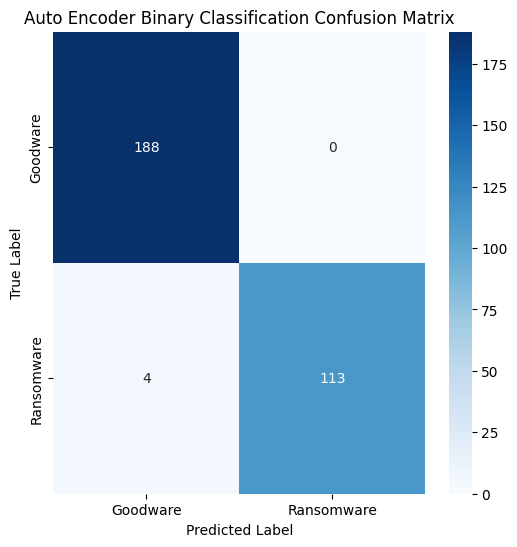

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


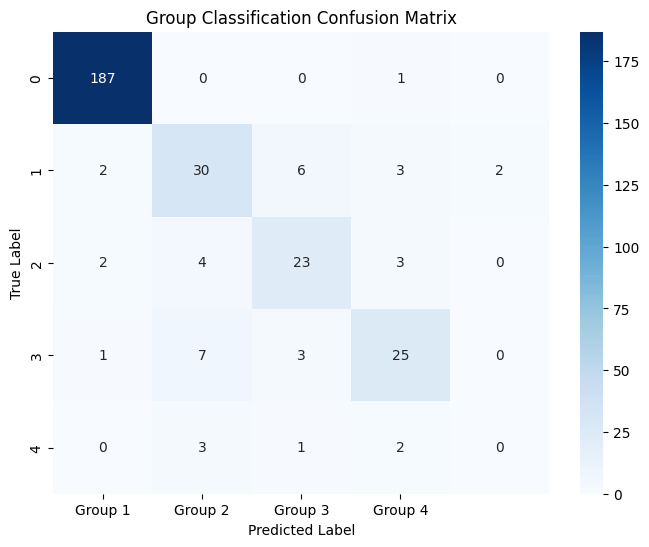

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


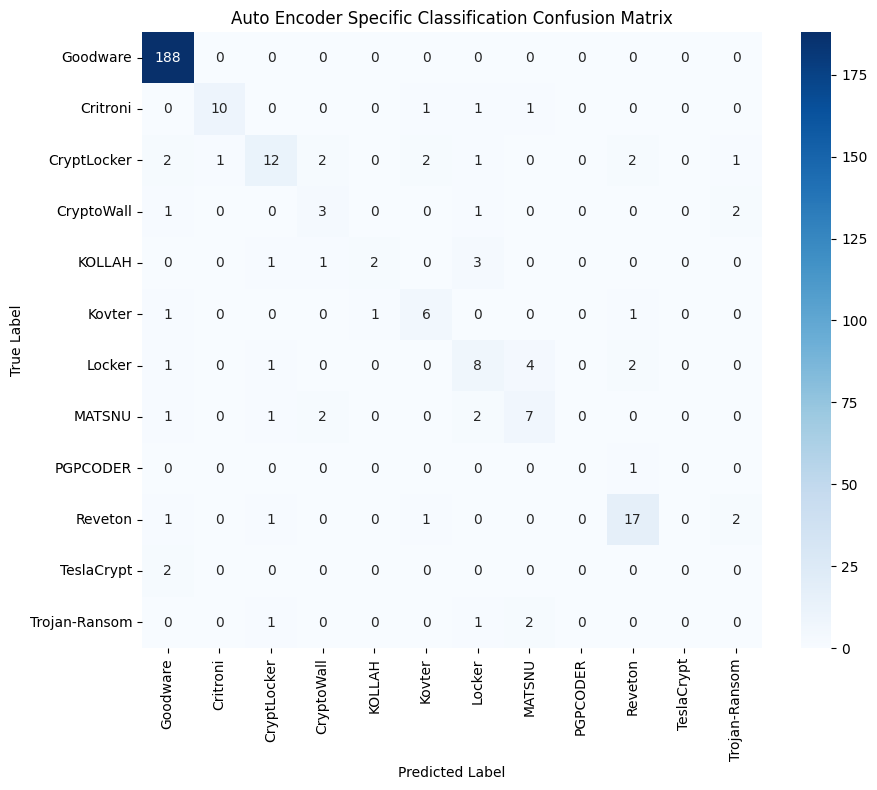

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


# Get predictions for binary classification head
y_binary_pred = model.predict(X_test_encoded)[0]
y_binary_pred_classes = (y_binary_pred > 0.5).astype("int32")


cm_binary = confusion_matrix(y_test_binary, y_binary_pred_classes)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.heatmap(cm_binary, annot=True, fmt="d", cmap="Blues", xticklabels=['Goodware', 'Ransomware'], yticklabels=['Goodware', 'Ransomware'])
plt.title('Auto Encoder Binary Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Get predictions for group classification head
y_group_pred = model.predict(X_test_encoded)[1]
y_group_pred_classes = y_group_pred.argmax(axis=1)

# Compute confusion matrix
cm_group = confusion_matrix(y_test_group, y_group_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_group, annot=True, fmt="d", cmap="Blues", xticklabels=['Group 1', 'Group 2', 'Group 3', 'Group 4'], yticklabels=range(5))
plt.title('Group Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Get predictions for specific classification head
y_specific_pred = model.predict(X_test_encoded)[2]
y_specific_pred_classes = y_specific_pred.argmax(axis=1)

# Compute confusion matrix
cm_specific = confusion_matrix(y_test, y_specific_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
specific_labels = ['Goodware', 'Critroni', 'CryptLocker', 'CryptoWall', 'KOLLAH', 'Kovter', 'Locker', 'MATSNU', 'PGPCODER', 'Reveton', 'TeslaCrypt', 'Trojan-Ransom']
sns.heatmap(cm_specific, annot=True, fmt="d", cmap="Blues", xticklabels=specific_labels, yticklabels=specific_labels)
plt.title('Auto Encoder Specific Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Generate predictions
predictions = model.predict(X_test_encoded)

# Binary predictions and metrics
binary_predictions = (predictions[0] > 0.5).astype(int)  # Convert probabilities to 0 or 1
binary_accuracy = accuracy_score(y_test_binary, binary_predictions)
binary_precision = precision_score(y_test_binary, binary_predictions)
binary_recall = recall_score(y_test_binary, binary_predictions)
binary_f1 = f1_score(y_test_binary, binary_predictions)
# Specific predictions and metrics
specific_predictions = np.argmax(predictions[1], axis=1)
specific_accuracy = accuracy_score(y_test, specific_predictions)
specific_precision = precision_score(y_test, specific_predictions, average='macro')
specific_recall = recall_score(y_test, specific_predictions, average='macro')
specific_f1 = f1_score(y_test, specific_predictions, average='macro')

# Print the results
print(f"Binary Classification Metrics:\n"
      f"Accuracy: {binary_accuracy:.4f}\n"
      f"Precision: {binary_precision:.4f}\n"
      f"Recall: {binary_recall:.4f}\n"
      f"F1 Score: {binary_f1:.4f}")

print(f"\nSpecific Classification Metrics:\n"
      f"Accuracy: {specific_accuracy:.4f}\n"
      f"Precision: {specific_precision:.4f}\n"
      f"Recall: {specific_recall:.4f}\n"
      f"F1 Score: {specific_f1:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Binary Classification Metrics:
Accuracy: 0.9803
Precision: 0.9826
Recall: 0.9658
F1 Score: 0.9741

Specific Classification Metrics:
Accuracy: 0.8066
Precision: 0.4159
Recall: 0.3997
F1 Score: 0.4015


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyError: 'binary_output_loss'

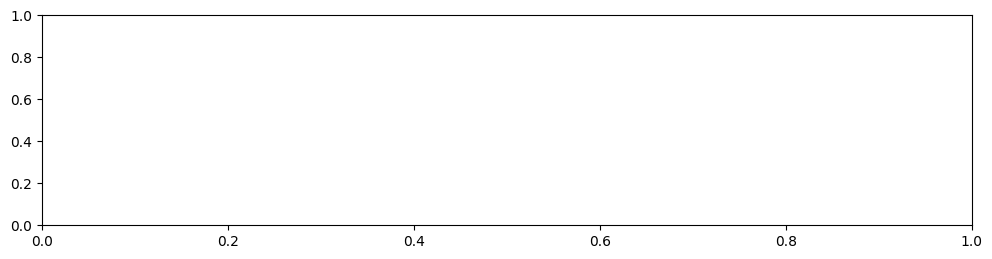

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(history.history['binary_output_loss'], linestyle='--', label='Binary Output Loss')
plt.plot(history.history['val_binary_output_loss'], label='Val Binary Output Loss')
plt.plot(history.history['group_output_loss'], linestyle='--', label='Group Output Loss')
plt.plot(history.history['val_group_output_loss'], label='Val Group Output Loss')
plt.plot(history.history['specific_output_loss'], linestyle='--', label='Specific Output Loss')
plt.plot(history.history['val_specific_output_loss'], label='Val Specific Output Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(2, 1, 2)
plt.plot(history.history['binary_output_accuracy'], linestyle='--', label='Binary Output Accuracy')
plt.plot(history.history['val_binary_output_accuracy'], label='Val Binary Output Accuracy')
plt.plot(history.history['group_output_accuracy'], linestyle='--', label='Group Output Accuracy')
plt.plot(history.history['val_group_output_accuracy'], label='Val Group Output Accuracy')
plt.plot(history.history['specific_output_accuracy'], linestyle='--', label='Specific Output Accuracy')
plt.plot(history.history['val_specific_output_accuracy'], label='Val Specific Output Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


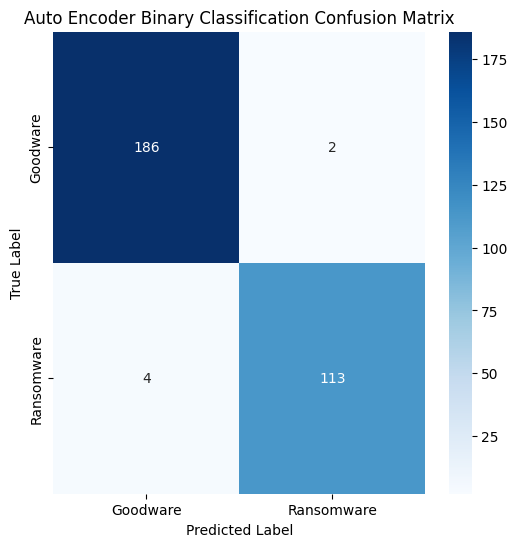

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


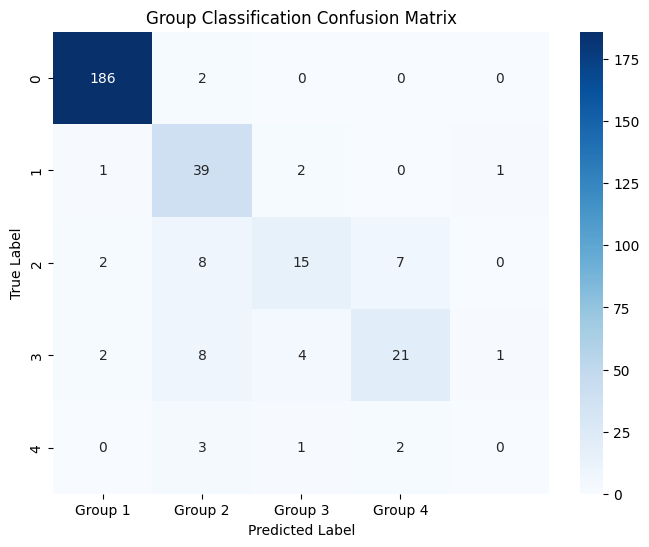

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


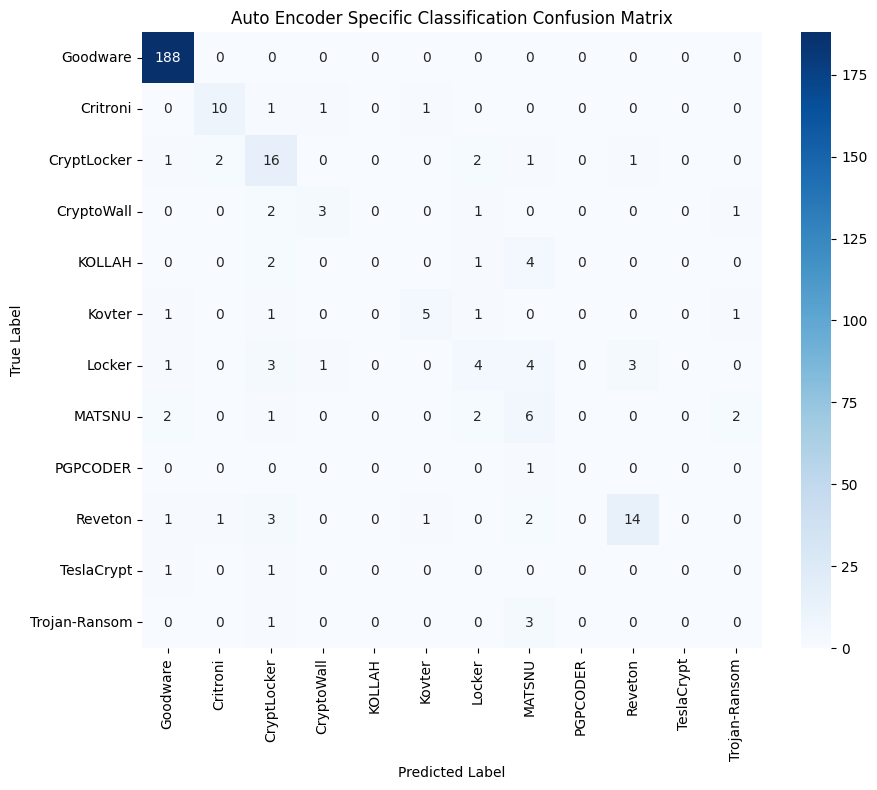

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


# Get predictions for binary classification head
y_binary_pred = model.predict(X_test_encoded)[0]
y_binary_pred_classes = (y_binary_pred > 0.5).astype("int32")


cm_binary = confusion_matrix(y_test_binary, y_binary_pred_classes)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.heatmap(cm_binary, annot=True, fmt="d", cmap="Blues", xticklabels=['Goodware', 'Ransomware'], yticklabels=['Goodware', 'Ransomware'])
plt.title('Auto Encoder Binary Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Get predictions for group classification head
y_group_pred = model.predict(X_test_encoded)[1]
y_group_pred_classes = y_group_pred.argmax(axis=1)

# Compute confusion matrix
cm_group = confusion_matrix(y_test_group, y_group_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_group, annot=True, fmt="d", cmap="Blues", xticklabels=['Group 1', 'Group 2', 'Group 3', 'Group 4'], yticklabels=range(5))
plt.title('Group Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Get predictions for specific classification head
y_specific_pred = model.predict(X_test_encoded)[2]
y_specific_pred_classes = y_specific_pred.argmax(axis=1)

# Compute confusion matrix
cm_specific = confusion_matrix(y_test, y_specific_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
specific_labels = ['Goodware', 'Critroni', 'CryptLocker', 'CryptoWall', 'KOLLAH', 'Kovter', 'Locker', 'MATSNU', 'PGPCODER', 'Reveton', 'TeslaCrypt', 'Trojan-Ransom']
sns.heatmap(cm_specific, annot=True, fmt="d", cmap="Blues", xticklabels=specific_labels, yticklabels=specific_labels)
plt.title('Auto Encoder Specific Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
